# Acquire (acquire.py)

## Zillow

For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

### acquire & summarize

1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.
    - ***Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for `airconditioningtypeid`.***
    - Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
    - Only include properties that include a latitude and longitude value.

In [42]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os
from env import host, user, password

from sklearn.model_selection import train_test_split

In [43]:
###################### Acquire Zillow Data ######################

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
def new_zillow_data():
    '''
    This function reads the zillow data from the Codeup db into a df,
    write it to a csv file, and returns the df.
    '''
    sql_query = '''
            SELECT *
            FROM properties_2017 as prop 
            INNER JOIN (
                    SELECT id, p.parcelid, logerror, transactiondate
                    FROM predictions_2017 AS p
                    INNER JOIN (
                            SELECT parcelid,  MAX(transactiondate) AS max_date
                            FROM predictions_2017 
                            GROUP BY (parcelid)
                    ) AS sub
                        ON p.parcelid = sub.parcelid
                    WHERE p.transactiondate = sub.max_date
            ) AS subq
                ON prop.id = subq.id;
                 '''
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df.to_csv('zillow.csv')
    return df

def get_zillow_data(cached=False):
    '''
    This function reads in titanic data from Codeup database if cached == False 
    or if cached == True reads in zillow df from a csv file, returns df
    '''
    if cached or os.path.isfile('zillow_df.csv') == False:
        df = new_zillow_data()
    else:
        df = pd.read_csv('zillow_df.csv', index_col=0)
    return df

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [44]:
df = get_zillow_data()

In [46]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,transactiondate
0,0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,2016.0,9.0,NaN,None,NaN,NaN,0,14297519,0.025595,2017-01-01
1,1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,2015.0,27516.0,NaN,None,NaN,NaN,1,17052889,0.055619,2017-01-01
2,2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,...,2016.0,774261.0,20800.37,None,NaN,NaN,2,14186244,0.005383,2017-01-01
3,3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,...,2016.0,594416.0,14557.57,None,NaN,NaN,3,12177905,-0.103410,2017-01-01
4,4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,...,2016.0,243350.0,5725.17,None,NaN,NaN,4,10887214,0.006940,2017-01-01


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77414 non-null  int64  
 1   parcelid                      77414 non-null  int64  
 2   airconditioningtypeid         21395 non-null  float64
 3   architecturalstyletypeid      151 non-null    float64
 4   basementsqft                  44 non-null     float64
 5   bathroomcnt                   77414 non-null  float64
 6   bedroomcnt                    77414 non-null  float64
 7   buildingclasstypeid           381 non-null    float64
 8   buildingqualitytypeid         50182 non-null  float64
 9   calculatedbathnbr             74202 non-null  float64
 10  decktypeid                    510 non-null    float64
 11  finishedfloor1squarefeet      5953 non-null   float64
 12  calculatedfinishedsquarefeet  76306 non-null  float64
 13  f

In [48]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,parcelid,logerror
count,77414.000000,7.741400e+04,21395.000000,151.000000,44.000000,77414.000000,77414.000000,381.000000,50182.000000,74202.000000,...,7.615000e+04,7.649000e+04,77414.000000,7.580800e+04,7.690500e+04,1502.000000,7.532400e+04,77414.000000,7.741400e+04,77414.000000
mean,38848.445307,1.337669e+07,1.926899,7.430464,601.613636,2.214632,3.084106,3.774278,6.300666,2.309661,...,1.787250e+05,4.405307e+05,2015.998217,2.649626e+05,5.368690e+03,13.920772,6.048976e+13,38848.445307,1.300670e+07,0.016578
std,22404.198916,8.324811e+06,3.132454,2.629347,462.680774,1.083171,1.275663,0.460514,1.726176,1.001730,...,4.021004e+05,8.339476e+05,0.068170,5.284760e+05,1.040392e+04,1.528231,2.100220e+11,22404.198916,3.480690e+06,0.170342
min,0.000000,1.071174e+07,1.000000,2.000000,63.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,5.000000e+00,8.000000e+00,2003.000000,4.000000e+00,2.540000e+00,6.000000,6.037101e+13,0.000000,1.071186e+07,-4.655420
25%,19459.250000,1.158595e+07,1.000000,7.000000,222.000000,2.000000,2.000000,4.000000,5.000000,2.000000,...,7.833650e+04,1.870282e+05,2016.000000,7.840075e+04,2.449780e+03,14.000000,6.037311e+13,19459.250000,1.153834e+07,-0.024387
50%,38871.500000,1.253280e+07,1.000000,7.000000,542.000000,2.000000,3.000000,4.000000,6.000000,2.000000,...,1.283935e+05,3.214315e+05,2016.000000,1.753420e+05,4.005480e+03,14.000000,6.037572e+13,38871.500000,1.253072e+07,0.006624
75%,58254.750000,1.411519e+07,1.000000,7.000000,744.500000,3.000000,4.000000,4.000000,8.000000,3.000000,...,2.055275e+05,5.129815e+05,2016.000000,3.246770e+05,6.198450e+03,15.000000,6.059042e+13,58254.750000,1.421149e+07,0.039211
max,77613.000000,1.696019e+08,13.000000,21.000000,2443.000000,20.000000,25.000000,5.000000,12.000000,20.000000,...,6.640493e+07,1.491392e+08,2016.000000,9.401108e+07,1.824155e+06,15.000000,6.111009e+13,77613.000000,1.676893e+08,5.262999


3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an attribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [49]:
def missing_rows_df(df):
    '''Takes in a dataframe of observations and attributes 
    and returns a dataframe where each row is an attribute name, 
    the first column is the number of rows with missing values 
    for that attribute, and the second column is percent of total 
    rows that have missing values for that attribute'''
    d = {'num_rows_missing': df.isna().sum(), 
         'pct_rows_missing': df.isna().sum()/len(df)}
    new_df = pd.DataFrame(data=d)
    return new_df

In [50]:
df_mr = missing_rows_df(df)
df_mr.head()

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,56019,0.723629
architecturalstyletypeid,77263,0.998049
basementsqft,77370,0.999432


In [51]:
cols_no_missing = df_mr[df_mr.num_rows_missing == 0].T.columns.to_list()
cols_no_missing

['id',
 'parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'fips',
 'latitude',
 'longitude',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcounty',
 'assessmentyear',
 'id',
 'parcelid',
 'logerror',
 'transactiondate']

In [52]:
cols_more_than_50pct_missing = df_mr[df_mr.pct_rows_missing > .5].T.columns.to_list()
cols_more_than_50pct_missing

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'regionidneighborhood',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

takeaways: 

4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [53]:
def missing_cols_df(df):
    '''takes in a dataframe and returns a dataframe 
    with 3 columns: the number of columns missing, 
    percent of columns missing, and number of rows 
    with n columns missing'''
    d = {'num_cols_missing': df.isna().sum(axis=1), 
         'pct_cols_missing': df.isna().sum(axis=1)/len(df.columns),
         'num_rows': 'fill'}
    new_df = pd.DataFrame(data=d)
    return new_df

In [54]:
missing_cols_df(df)

,num_cols_missing,pct_cols_missing,num_rows
0,41,0.650794,fill
1,40,0.634921,fill
2,32,0.507937,fill
3,31,0.492063,fill
4,31,0.492063,fill
...,...,...,...
77409,28,0.444444,fill
77410,28,0.444444,fill
77411,28,0.444444,fill
77412,28,0.444444,fill


In [55]:
df.isna().sum(axis=1).value_counts().index

Int64Index([28, 29, 27, 26, 30, 25, 31, 32, 40, 24, 39, 23, 33, 34, 22, 41, 38,
            37, 42, 35, 36, 21, 43, 20, 44, 19],
           dtype='int64')

In [56]:
df.isna().sum(axis=1).value_counts().sort_values()

19        1
44        3
20        8
43       38
21       50
36       63
35       71
42       92
37      120
38      123
41      210
22      235
34      306
33      339
23      435
39      449
24      557
40      996
32     1536
31     2948
25     4777
30     6470
26     7159
27    11352
29    18500
28    20576
dtype: int64

### Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [57]:
prop = pd.Series([260, 261, 263, 273, 275, 279, 276])
df_su = df[(df.propertylandusetypeid.isin(prop))]
df_su.shape

(57748, 63)

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

    - The input:
        - A dataframe
        - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
        - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
    - The output:
        - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
    - hint:
        - Look up the dropna documentation.
        - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
        - Make use of inplace, i.e. inplace=True/False.

In [58]:
def handle_missing_values(df, prop_required_column, prop_required_row):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [59]:
df1 = handle_missing_values(df_su, .85, .75)

In [60]:
df1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id,parcelid,logerror,transactiondate
1,1,10759547,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34140430.0,...,NaN,27516.0,2015.0,27516.0,NaN,NaN,1,17052889,0.055619,2017-01-01
6,6,10933547,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34131929.0,...,404013.0,563029.0,2016.0,159016.0,6773.34,NaN,6,12095076,-0.001011,2017-01-01
15,15,11193347,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34585014.0,...,NaN,10.0,2016.0,10.0,NaN,NaN,15,17110996,0.008669,2017-01-02
16,16,11215747,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34563376.0,...,NaN,10.0,2016.0,10.0,NaN,NaN,16,14375300,-0.021896,2017-01-02
17,17,11229347,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34526913.0,...,NaN,2108.0,2016.0,2108.0,174.21,NaN,17,12045625,-0.017167,2017-01-02


3. Decide how to handle the remaining missing values:

    - Fill with constant value.
    - Impute with mean, median, mode.
    - Drop row/column

In [41]:
df1.isna().sum()

id                                 0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr               1928
calculatedfinishedsquarefeet     811
finishedsquarefeet12            1197
fips                               0
fullbathcnt                     1928
latitude                           0
longitude                          0
lotsizesquarefeet               1858
propertycountylandusecode          0
propertylandusetypeid              0
rawcensustractandblock             0
regionidcity                    1062
regionidcounty                     0
regionidzip                       75
roomcnt                            0
yearbuilt                        826
structuretaxvaluedollarcnt      1003
taxvaluedollarcnt                832
assessmentyear                     0
landtaxvaluedollarcnt           1485
taxamount                        333
censustractandblock             1165
id                                 0
p

In [25]:
df2 = df1.dropna()
df2.isna().sum()

id                              0
parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
id                              0
parcelid                        0
logerror                        0
transactiondat

## Mall Customers

1. Acquire data from mall_customers.customers in mysql database.

In [26]:
###################### Acquire Zillow Data ######################

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
def new_mall_data():
    '''
    This function reads the mall data from the Codeup db into a df,
    write it to a csv file, and returns the df.
    '''
    sql_query = '''SELECT * FROM customers
                 '''
    df = pd.read_sql(sql_query, get_connection('mall_customers'))
    df.to_csv('mall_customers.csv')
    return df

def get_mall_data(cached=False):
    '''
    This function reads in mall data from Codeup database if cached == False 
    or if cached == True reads in mall df from a csv file, returns df
    '''
    if cached or os.path.isfile('mall_df.csv') == False:
        df = new_mall_data()
    else:
        df = pd.read_csv('mall_df.csv', index_col=0)
    return df

In [27]:
mall = get_mall_data()
mall.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


2. Summarize data (include distributions and descriptive statistics).

In [28]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [29]:
mall.drop(columns='customer_id').describe().T

,count,mean,std,min,25%,50%,75%,max
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


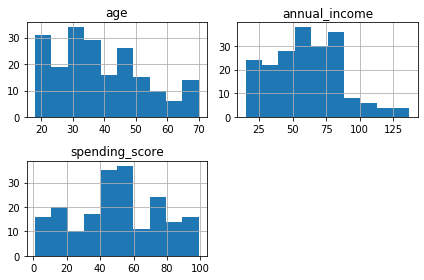

In [31]:
mall.drop(columns='customer_id').hist()
plt.tight_layout()

3. Detect outliers using IQR.

In [ ]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [ ]:
get_upper_outliers(mall.age, 1.5).sum()

In [ ]:
get_upper_outliers(mall.spending_score, 1.5).sum()

In [ ]:
get_upper_outliers(mall.annual_income, 1.5).sum()

In [ ]:
get_upper_outliers(mall.annual_income, 1.5).value_counts()

In [ ]:
(get_upper_outliers(mall.annual_income, 1.5) == 4.25).sum()

In [ ]:
(get_upper_outliers(mall.annual_income, 1.5) == 4.25)

In [ ]:
def get_lower_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the lower outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the lower bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    return s.apply(lambda x: max([lower_bound - x, 0]))

In [ ]:
get_lower_outliers(mall.age, 1.5).sum()

In [ ]:
get_lower_outliers(mall.annual_income, 1.5).sum()

In [ ]:
get_lower_outliers(mall.spending_score, 1.5).sum()

4. Split data (train, validate, and test split).

In [ ]:
def mall_split(df):
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test

In [ ]:
train, validate, test = mall_split(mall)
train.shape, validate.shape, test.shape

5. Encode categorical columns using a one hot encoder.

In [ ]:
train.nunique()

In [ ]:
def one_hot_encoder(train, validate, test, cols):
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, categories='auto')

    # fit and transform train to create an array
    train_matrix = ohe.fit_transform(train[cols])

    # transform validate and test to create arrays
    validate_matrix = ohe.transform(validate[cols])
    test_matrix = ohe.transform(test[cols])
    
    # convert arrays to dataframes of encoded column
    train_ohe = pd.DataFrame(train_matrix, columns=ohe.categories_[0], index=train.index)
    validate_ohe = pd.DataFrame(validate_matrix, columns=ohe.categories_[0], index=validate.index)
    test_ohe = pd.DataFrame(test_matrix, columns=ohe.categories_[0], index=test.index)

    # join to the original datasets
    train = train.join(train_ohe)
    validate = validate.join(validate_ohe)
    test = test.join(test_ohe)
    return train, validate, test

In [ ]:
train, validate, test = one_hot_encoder(train, validate, test, ['gender'])
train.head()

6. Handles missing values.

In [ ]:
train.isna().sum()

In [ ]:
validate.isna().sum()

In [ ]:
test.isna().sum()

7. Scaling

In [ ]:
cols_to_scale = ['age', 'annual_income', 'spending_score', 'Male']

X_train = train[cols_to_scale]
X_validate = validate[cols_to_scale]
X_test = test[cols_to_scale]

In [ ]:
def min_max_scale(X_train, X_validate, X_test):
    # import scaler
    from sklearn.preprocessing import MinMaxScaler
    # Create scaler object
    scaler = MinMaxScaler(copy=True).fit(X_train)
    
    # tranform into scaled data (arrays)
    X_train_scaled = scaler.transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)
    X_test_scaled = scaler.transform(X_test)
    
    # Create dataframes out of the scaled arrays that were generated by the scaler tranform.
    X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns=X_train.columns.values).\
                            set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled, 
                                columns=X_validate.columns.values).\
                            set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled, 
                                columns=X_test.columns.values).\
                            set_index([X_test.index.values])
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [ ]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test)
X_train_scaled.head()

### Test Final .py files

In [4]:
from wrangle_zillow import wrangle_zillow

wrangle_zillow().head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id,parcelid,logerror,transactiondate
336,337,17051828,4.0,4.0,4.0,4969.0,4969.0,6111.0,4.0,34433200.0,...,779712.0,2228473.0,2016.0,1448761.0,24556.86,6.111001e+13,337,14688177,0.006783,2017-01-03
337,338,17052152,2.0,3.0,2.0,1800.0,1800.0,6111.0,2.0,34464778.0,...,319803.0,794940.0,2016.0,475137.0,8571.20,6.111001e+13,338,10930942,0.054386,2017-01-03
338,339,17052992,1.0,2.0,1.0,780.0,780.0,6111.0,1.0,34450686.0,...,70231.0,88731.0,2016.0,18500.0,1652.36,6.111001e+13,339,17246711,0.011061,2017-01-03
339,340,17053038,2.0,2.0,2.0,1250.0,1250.0,6111.0,2.0,34448639.0,...,79575.0,233424.0,2016.0,153849.0,3191.16,6.111001e+13,340,12559816,0.061977,2017-01-03
340,341,17053061,1.0,2.0,1.0,1404.0,1404.0,6111.0,1.0,34450089.0,...,99853.0,313844.0,2016.0,213991.0,3987.00,6.111001e+13,341,14673239,0.010089,2017-01-03


In [3]:
from wrangle_mall import wrangle_mall

train, validate, test = wrangle_mall()
train.head()

,age,annual_income,spending_score,Male
123,0.403846,0.442623,0.957447,1.0
76,0.519231,0.319672,0.553191,0.0
171,0.192308,0.590164,0.787234,1.0
10,0.942308,0.032787,0.138298,1.0
35,0.057692,0.147541,0.851064,0.0
